# Aneurysm Data Visualiser

This notebook focuses on loading and preparing aneurysm simulation data for visualization.

In [97]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from pathlib import Path
from IPython.display import HTML, display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

## Define Paths to Aneurysm Data

Locate and set paths to the aneurysm simulation result files.

In [98]:
# Define the base directory
base_dir = Path.cwd()

# Define the directory for aneurysm simulation results
# Try multiple possible locations
possible_paths = [
    base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh',
    base_dir / 'results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh',
    base_dir / '../simulation_output/aneurysm_flow'
]

# Find the first path that exists
aneurysm_folder = None
for path in possible_paths:
    if path.exists():
        aneurysm_folder = path
        break

if aneurysm_folder is None:
    print("Could not find aneurysm data folder. Please provide the correct path:")
    aneurysm_folder = input("Enter the path to aneurysm data: ")
    aneurysm_folder = Path(aneurysm_folder)

print(f"Using aneurysm data from: {aneurysm_folder}")

# Path to the parameter file (if exists)
param_file = aneurysm_folder / 'parameters' / 'aneurysm_params.json'

# Path to the processed data directory (if exists)
processed_dir = aneurysm_folder / 'processed_data' / 'raw_fields'

# Check what we have available
print(f"\nChecking available aneurysm data files...")
if param_file.exists():
    print(f"✓ Parameter file found: {param_file}")
else:
    print(f"✗ Parameter file not found at {param_file}")

if processed_dir.exists():
    print(f"✓ Processed data directory found: {processed_dir}")
    # List available data files
    data_files = list(processed_dir.glob('*.npz'))
    print(f"  Found {len(data_files)} data files:")
    for file in data_files[:10]:  # Show first 10 files
        print(f"  - {file.name}")
    if len(data_files) > 10:
        print(f"  ... and {len(data_files) - 10} more files")
else:
    print(f"✗ Processed data directory not found at {processed_dir}")
    # Look for alternative data locations
    raw_files = list(aneurysm_folder.glob('*.npy'))
    if raw_files:
        print(f"  Found {len(raw_files)} raw data files in main directory")
        for file in raw_files[:5]:
            print(f"  - {file.name}")

Using aneurysm data from: /home/abdua786/code/uni/3/dissertation/dissertation/results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh

Checking available aneurysm data files...
✓ Parameter file found: /home/abdua786/code/uni/3/dissertation/dissertation/results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/parameters/aneurysm_params.json
✓ Processed data directory found: /home/abdua786/code/uni/3/dissertation/dissertation/results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/processed_data/raw_fields
  Found 12 data files:
  - frame_mapping.npz
  - outlet_mask.npz
  - inlet_mask.npz
  - u_magnitude.npz
  - wss_y.npz
  - dimensions.npz
  - u_x.npz
  - u_y.npz
  - wss_x.npz
  - wss_magnitude.npz
  ... and 2 more files


## Load Simulation Parameters

Load and display the simulation parameters if available.

In [99]:
# Load simulation parameters
params = {}
if param_file.exists():
    try:
        with open(param_file, 'r') as f:
            params = json.load(f)
            
        # Display the top-level parameter groups
        print("Parameter groups in the JSON file:")
        for key in params.keys():
            print(f"- {key}")
            
        # Extract key simulation parameters
        try:
            # Time and space parameters
            dt = params['input_parameters'].get('dt', None)
            dx = params['input_parameters'].get('dx', None)
            fps = params['input_parameters'].get('fps', None)
            
            # Physical dimensions
            vessel_length_mm = params['input_parameters'].get('vessel_length_mm', None)
            vessel_diameter_mm = params['input_parameters'].get('vessel_diameter_mm', None)
            
            # Create a DataFrame with these parameters for better display
            param_df = pd.DataFrame({
                'Parameter': ['Time Step (dt)', 'Spatial Resolution (dx)', 'FPS', 
                              'Vessel Length', 'Vessel Diameter'],
                'Value': [dt, dx, fps, vessel_length_mm, vessel_diameter_mm],
                'Unit': ['seconds', 'meters', 'frames/second', 'mm', 'mm']
            })
            
            # Display the key parameters
            display(HTML(param_df.to_html(index=False)))
            
        except KeyError as e:
            print(f"Error: Could not find parameter {e} in the JSON file.")
            print("Check the structure of the parameter file.")
            
    except Exception as e:
        print(f"Error loading parameter file: {e}")
else:
    print("No parameter file found. Will use default parameters if needed.")
    # Set some reasonable defaults
    dt = 1.0
    dx = 1.0

Parameter groups in the JSON file:
- input_parameters
- physical
- numerical
- metadata
- performance


Parameter,Value,Unit
Time Step (dt),0.00001,seconds
Spatial Resolution (dx),0.00002,meters
FPS,100.00000,frames/second
Vessel Length,15.00000,mm
Vessel Diameter,6.50000,mm


## Load Aneurysm Simulation Data

Load the raw simulation data files.

In [100]:
def load_aneurysm_data():
    """Load available aneurysm simulation data"""
    data = {}
    
    # First check if we have processed data directory
    if processed_dir.exists():
        print(f"Loading data from processed directory: {processed_dir}")
        
        try:
            # Load dimensions info if available
            if (processed_dir / 'dimensions.npz').exists():
                data['dimensions'] = np.load(processed_dir / 'dimensions.npz')['data']
                print(f"Loaded dimensions: {data['dimensions']}")
            
            # Load velocity components (first frame only initially)
            if (processed_dir / 'u_x.npz').exists():
                # Load first frame of velocity data
                data['u_x'] = np.load(processed_dir / 'u_x.npz')['data'][0]  # First frame
                print(f"Loaded x-velocity with shape: {data['u_x'].shape}")
                
            if (processed_dir / 'u_y.npz').exists():
                data['u_y'] = np.load(processed_dir / 'u_y.npz')['data'][0]  # First frame
                print(f"Loaded y-velocity with shape: {data['u_y'].shape}")
            
            # Load velocity magnitude if available
            if (processed_dir / 'u_magnitude.npz').exists():
                data['u_magnitude'] = np.load(processed_dir / 'u_magnitude.npz')['data'][0]  # First frame
                print(f"Loaded velocity magnitude with shape: {data['u_magnitude'].shape}")
            
            # Load density if available
            if (processed_dir / 'rho.npz').exists():
                data['rho'] = np.load(processed_dir / 'rho.npz')['data'][0]  # First frame
                print(f"Loaded density field with shape: {data['rho'].shape}")
            
            # Load wall mask for domain visualization
            if (processed_dir / 'wall_mask.npz').exists():
                data['wall_mask'] = np.load(processed_dir / 'wall_mask.npz')['data'][0]  # First frame
                print(f"Loaded wall mask with shape: {data['wall_mask'].shape}")
            
            # Load WSS components if available
            if (processed_dir / 'wss_x.npz').exists():
                data['wss_x'] = np.load(processed_dir / 'wss_x.npz')['data'][0]  # First frame
                print(f"Loaded WSS x-component with shape: {data['wss_x'].shape}")
            
            if (processed_dir / 'wss_y.npz').exists():
                data['wss_y'] = np.load(processed_dir / 'wss_y.npz')['data'][0]  # First frame
                print(f"Loaded WSS y-component with shape: {data['wss_y'].shape}")
            
            if (processed_dir / 'wss_magnitude.npz').exists():
                data['wss_magnitude'] = np.load(processed_dir / 'wss_magnitude.npz')['data'][0]  # First frame
                print(f"Loaded WSS magnitude with shape: {data['wss_magnitude'].shape}")
            
            # Load frame mapping for time information
            if (processed_dir / 'frame_mapping.npz').exists():
                frame_data = np.load(processed_dir / 'frame_mapping.npz')
                data['frame_numbers'] = frame_data['frame_numbers']
                if 'physical_times' in frame_data:
                    data['physical_times'] = frame_data['physical_times']
                else:
                    # Calculate physical times from frame numbers and dt
                    data['physical_times'] = data['frame_numbers'] * dt
                print(f"Loaded time mapping for {len(data['frame_numbers'])} frames")
        
        except Exception as e:
            print(f"Error loading data from processed directory: {e}")
    
    # If we didn't find processed data, try looking for raw data files
    if not data and aneurysm_folder.exists():
        print(f"\nLooking for raw data files in: {aneurysm_folder}")
        
        # Try common filenames for velocity and density
        velocity_files = ['velocity_x.npy', 'velocity_y.npy', 'u.npy', 'v.npy']
        density_files = ['density.npy', 'rho.npy']
        mask_files = ['wall_mask.npy', 'domain_mask.npy', 'mask.npy']
        
        # Check for velocity files
        for vfile in velocity_files:
            vpath = aneurysm_folder / vfile
            if vpath.exists():
                field_name = vfile.split('.')[0]
                data[field_name] = np.load(vpath)
                print(f"Loaded {field_name} with shape: {data[field_name].shape}")
        
        # Check for density files
        for dfile in density_files:
            dpath = aneurysm_folder / dfile
            if dpath.exists():
                field_name = dfile.split('.')[0]
                data[field_name] = np.load(dpath)
                print(f"Loaded {field_name} with shape: {data[field_name].shape}")
        
        # Check for mask files
        for mfile in mask_files:
            mpath = aneurysm_folder / mfile
            if mpath.exists():
                field_name = mfile.split('.')[0]
                data[field_name] = np.load(mpath)
                print(f"Loaded {field_name} with shape: {data[field_name].shape}")
    
    # Check if we have any data
    if not data:
        print("No aneurysm data files could be found or loaded.")
    else:
        print(f"\nSuccessfully loaded {len(data)} data fields")
    
    return data

# Load the aneurysm data
aneurysm_data = load_aneurysm_data()

# Display summary of loaded data
print("\nSummary of loaded aneurysm data:")
if aneurysm_data:
    for key, value in aneurysm_data.items():
        if isinstance(value, np.ndarray):
            print(f"- {key}: shape {value.shape}, dtype {value.dtype}, range [{value.min()}, {value.max()}]")
        else:
            print(f"- {key}: {type(value)}, length {len(value) if hasattr(value, '__len__') else 'N/A'}")

Loading data from processed directory: /home/abdua786/code/uni/3/dissertation/dissertation/results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/processed_data/raw_fields
Loaded dimensions: [752 531   1]
Loaded x-velocity with shape: (530, 751)
Loaded x-velocity with shape: (530, 751)
Loaded y-velocity with shape: (530, 751)
Loaded y-velocity with shape: (530, 751)
Loaded velocity magnitude with shape: (530, 751)
Loaded velocity magnitude with shape: (530, 751)
Loaded density field with shape: (530, 751)
Loaded density field with shape: (530, 751)
Loaded wall mask with shape: (530, 751)
Loaded wall mask with shape: (530, 751)
Loaded WSS x-component with shape: (530, 751)
Loaded WSS x-component with shape: (530, 751)
Loaded WSS y-component with shape: (530, 751)
Loaded WSS y-component with shape: (530, 751)
Loaded WSS magnitude with shape: (530, 751)
Loaded time mapping for 101 frames

Successfully loaded 11 data fields

Summary of loaded aneurysm data:
- dimensions: shape (3,), dtype

## Data Availability Summary

Summarize what data is available for further analysis.

In [101]:
def summarize_data_availability(data):
    """Provide a summary of available data and next steps"""
    if not data:
        print("No aneurysm data is available.")
        return
    
    # Check which key data types are available
    has_velocity = ('u_x' in data and 'u_y' in data) or ('velocity_x' in data and 'velocity_y' in data)
    has_density = 'rho' in data or 'density' in data
    has_mask = 'wall_mask' in data or 'domain_mask' in data or 'mask' in data
    has_multiple_frames = ('frame_numbers' in data and len(data['frame_numbers']) > 1)
    
    print("\nAneurysm Data Availability Summary:")
    print(f"✓ Velocity fields: {'Available' if has_velocity else 'Not available'}")
    print(f"✓ Density field: {'Available' if has_density else 'Not available'}")
    print(f"✓ Domain/wall mask: {'Available' if has_mask else 'Not available'}")
    print(f"✓ Time series data: {'Available ({} frames)'.format(len(data['frame_numbers'])) if has_multiple_frames else 'Only single frame available'}")
    
    # Suggest next steps based on available data
    print("\nSuggested Next Steps:")
    if has_velocity:
        print("- Create detailed velocity field visualizations")
        if has_multiple_frames:
            print("- Generate velocity field animations over time")
    
    if has_density:
        print("- Analyze density distribution patterns")
    
    if has_mask:
        print("- Overlay flow data with domain boundaries")
    
    if has_velocity and has_mask:
        print("- Calculate wall shear stress and other boundary-related metrics")

# Summarize data availability
summarize_data_availability(aneurysm_data)

print("\nAneurysm data loading complete. The data is now ready for further visualization and analysis.")


Aneurysm Data Availability Summary:
✓ Velocity fields: Available
✓ Density field: Available
✓ Domain/wall mask: Available
✓ Time series data: Available (101 frames)

Suggested Next Steps:
- Create detailed velocity field visualizations
- Generate velocity field animations over time
- Analyze density distribution patterns
- Overlay flow data with domain boundaries
- Calculate wall shear stress and other boundary-related metrics

Aneurysm data loading complete. The data is now ready for further visualization and analysis.


## Velocity Field Visualization at Specific Time (t=0.2s)

Extract and visualize the velocity field at a specific time point (t=0.2s) to examine flow patterns in the aneurysm.

Loading velocity field at t = 0.200s (frame 20000, closest to target t = 0.2s)


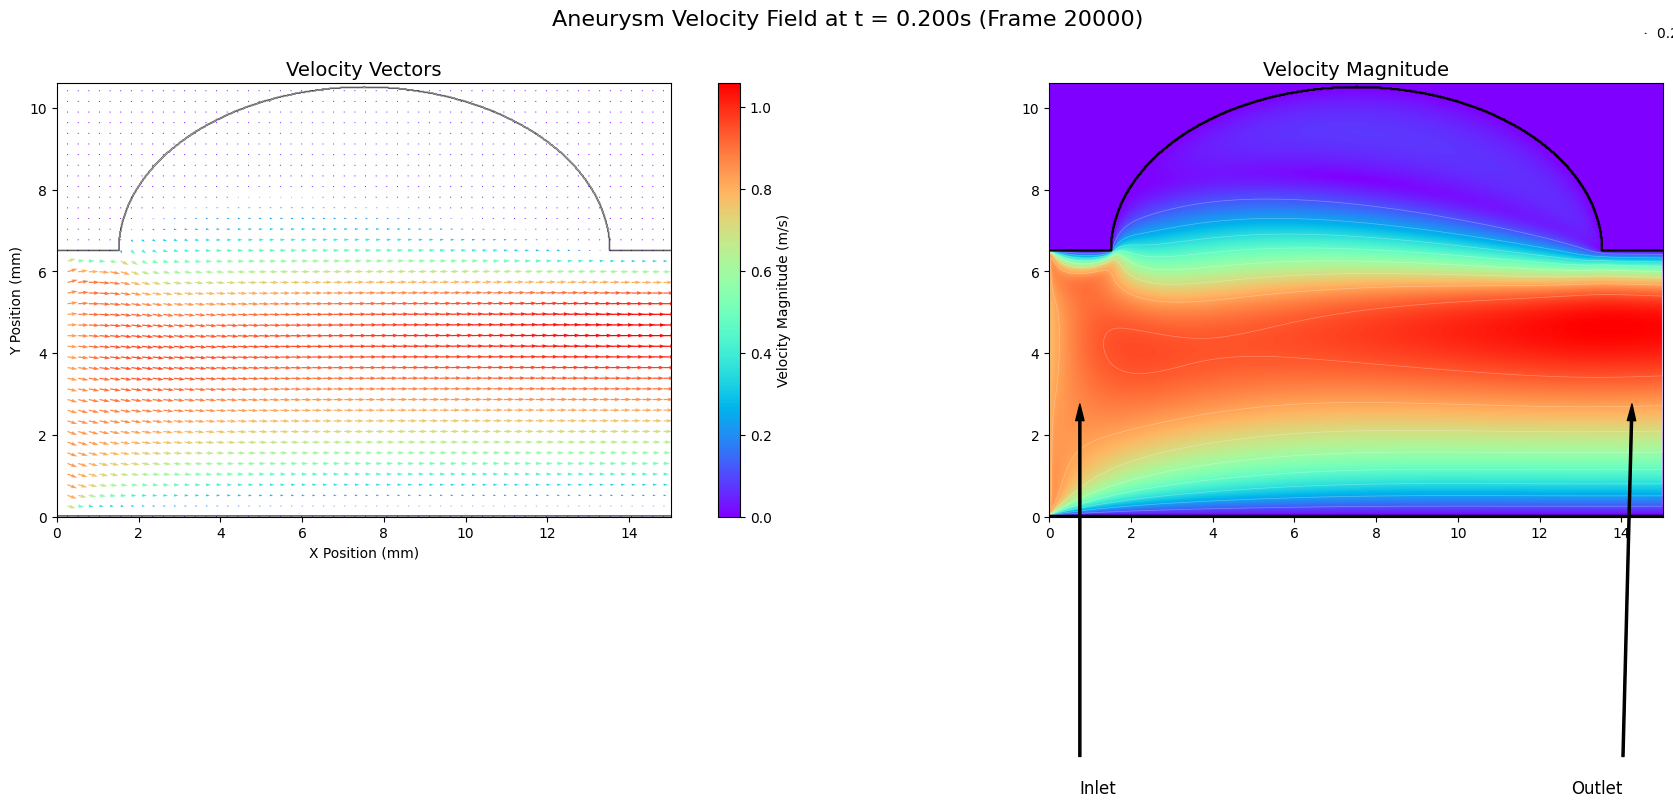


Velocity Statistics:
Mean velocity magnitude: 0.465897 m/s
Max velocity magnitude: 1.058914 m/s
Min velocity magnitude: 0.000000 m/s

Reynolds number: 913.69
Flow regime: Laminar


In [102]:
def load_velocity_at_time(target_time=0.2):
    """Load velocity field data at a specific time point"""
    if not processed_dir.exists():
        print(f"Processed data directory not found at {processed_dir}")
        return None
    
    # Files we need to load
    u_x_file = processed_dir / 'u_x.npz'
    u_y_file = processed_dir / 'u_y.npz'
    wall_mask_file = processed_dir / 'wall_mask.npz'
    frame_mapping_file = processed_dir / 'frame_mapping.npz'
    
    if not u_x_file.exists() or not u_y_file.exists() or not frame_mapping_file.exists():
        print("Required velocity or frame mapping files not found.")
        return None
    
    try:
        # Load frame mapping to find the correct time point
        frame_mapping = np.load(frame_mapping_file)
        frame_numbers = frame_mapping['frame_numbers']
        
        # Convert to physical time
        physical_times = frame_numbers * dt
        
        # Find the frame closest to the target time
        target_idx = np.argmin(np.abs(physical_times - target_time))
        actual_time = physical_times[target_idx]
        frame_num = frame_numbers[target_idx]
        
        print(f"Loading velocity field at t = {actual_time:.3f}s (frame {frame_num}, closest to target t = {target_time:.1f}s)")
        
        # Load velocity components at the target time
        u_x_data = np.load(u_x_file)['data'][target_idx]
        u_y_data = np.load(u_y_file)['data'][target_idx]
        
        # Load wall mask if available
        wall_mask = None
        if wall_mask_file.exists():
            try:
                wall_mask_data = np.load(wall_mask_file)['data']
                if wall_mask_data.ndim == 3:  # Multi-frame data
                    wall_mask = wall_mask_data[target_idx]
                else:  # Single frame data
                    wall_mask = wall_mask_data
            except Exception as e:
                print(f"Error loading wall mask: {e}")
        
        return {
            'u_x': u_x_data,
            'u_y': u_y_data,
            'wall_mask': wall_mask,
            'time': actual_time,
            'frame': frame_num
        }
        
    except Exception as e:
        print(f"Error loading velocity field at specified time: {e}")
        import traceback
        traceback.print_exc()
        return None

def visualize_velocity_field_at_time(velocity_data):
    """Create comprehensive visualization of velocity field at specific time"""
    if velocity_data is None or 'u_x' not in velocity_data or 'u_y' not in velocity_data:
        print("No velocity data available to visualize")
        return
    
    # Extract data
    u = velocity_data['u_x']
    v = velocity_data['u_y']
    wall_mask = velocity_data.get('wall_mask', None)
    time_sec = velocity_data.get('time', 0.0)
    frame_num = velocity_data.get('frame', 0)
    
    # Calculate velocity magnitude
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain dimensions in physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Create meshgrid for quiver plot
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Create a 2x1 plot layout: velocity vectors and velocity magnitude
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 40)
    
    # Title for the entire figure
    fig.suptitle(f"Aneurysm Velocity Field at t = {time_sec:.3f}s (Frame {frame_num})", fontsize=16)
    
    # Plot 1: Vector field
    ax1.set_title('Velocity Vectors', fontsize=14)
    
    # If wall mask is available, use it to show the fluid domain
    if wall_mask is not None:
        # Create a custom colormap for the domain
        domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
        ax1.imshow(wall_mask, cmap=domain_cmap, alpha=0.2, origin='lower', extent=extent_mm)
        # Add domain boundary outline
        ax1.contour(x_mm, y_mm, wall_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    # Add quiver plot (velocity vectors)
    quiver = ax1.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                      u_phys[::skip, ::skip], v_phys[::skip, ::skip],
                      vel_mag_phys[::skip, ::skip], cmap='rainbow',
                      scale=50, width=0.002)
    
    # Add quiver key for scale reference
    ax1.quiverkey(quiver, 0.9, 0.95, 0.2, r'0.2 m/s', labelpos='E', coordinates='figure')
    
    # Add colorbar
    cbar1 = plt.colorbar(quiver, ax=ax1)
    cbar1.set_label('Velocity Magnitude (m/s)')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Plot 2: Velocity magnitude heatmap
    ax2.set_title('Velocity Magnitude', fontsize=14)
    
    im = ax2.imshow(vel_mag_phys, origin='lower', cmap='rainbow', 
                   interpolation='bilinear', extent=extent_mm)
    
    # Add contour lines to better show flow patterns
    contour_levels = np.linspace(vel_mag_phys.min(), vel_mag_phys.max(), 10)
    ax2.contour(x_mm, y_mm, vel_mag_phys, levels=contour_levels, 
              colors='white', alpha=0.3, linewidths=0.5)
    
    # Add domain boundary if wall mask available
    if wall_mask is not None:
        ax2.contour(x_mm, y_mm, wall_mask, levels=[0.5], 
                  colors='black', linewidths=1.0)
    
    # Add annotations for key regions if dimensions match expectations
    vessel_center_y = None
    if 'vessel_centre_lu' in params.get('input_parameters', {}):
        vessel_center_y = params['input_parameters']['vessel_centre_lu'] * dx * 1000
    elif ny > 400:  # Approximate for typical aneurysm dimensions
        vessel_center_y = ny * dx * 1000 / 3  # Approximate vessel center
    
    if vessel_center_y is not None:
        # Domain width in mm
        domain_width_mm = nx * dx * 1000
        
        # Annotate key regions
        ax2.annotate('Inlet', xy=(domain_width_mm*0.05, vessel_center_y), 
                    xytext=(domain_width_mm*0.05, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        # Look for region with higher velocity (potential aneurysm)
        # In typical aneurysm, the dome would be in the middle-top region
        ax2.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_y+15),
                    xytext=(domain_width_mm*0.5, vessel_center_y+30),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax2.annotate('Outlet', xy=(domain_width_mm*0.95, vessel_center_y),
                    xytext=(domain_width_mm*0.85, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()
    
    # Print velocity statistics
    print("\nVelocity Statistics:")
    print(f"Mean velocity magnitude: {np.mean(vel_mag_phys):.6f} m/s")
    print(f"Max velocity magnitude: {np.max(vel_mag_phys):.6f} m/s")
    print(f"Min velocity magnitude: {np.min(vel_mag_phys):.6f} m/s")
    
    # Calculate Reynolds number if we have vessel diameter
    if 'vessel_diameter_mm' in params.get('input_parameters', {}):
        try:
            vessel_diameter_m = params['input_parameters']['vessel_diameter_mm'] / 1000  # m
            kinematic_viscosity = params['input_parameters'].get('kinematic_viscosity', 3.3e-6)  # m²/s (approximate for blood)
            mean_velocity = np.mean(vel_mag_phys)  # m/s
            reynolds_number = (mean_velocity * vessel_diameter_m) / kinematic_viscosity
            print(f"\nReynolds number: {reynolds_number:.2f}")
            if reynolds_number < 2000:
                print("Flow regime: Laminar")
            elif reynolds_number < 4000:
                print("Flow regime: Transitional")
            else:
                print("Flow regime: Turbulent")
        except Exception as e:
            print(f"Could not calculate Reynolds number: {e}")

# Load velocity data at t=0.2s
velocity_field_t02 = load_velocity_at_time(target_time=0.2)

# Visualize the velocity field
if velocity_field_t02:
    visualize_velocity_field_at_time(velocity_field_t02)
else:
    print("Could not load velocity field data for t=0.2s")

## Enhanced Velocity Field Visualization with Separate Streamlines and Vectors

Create a three-panel visualization showing streamlines, velocity vectors, and velocity magnitude separately for better analysis of the flow patterns.

Loading velocity field at t = 0.200s (frame 20000, closest to target t = 0.2s)


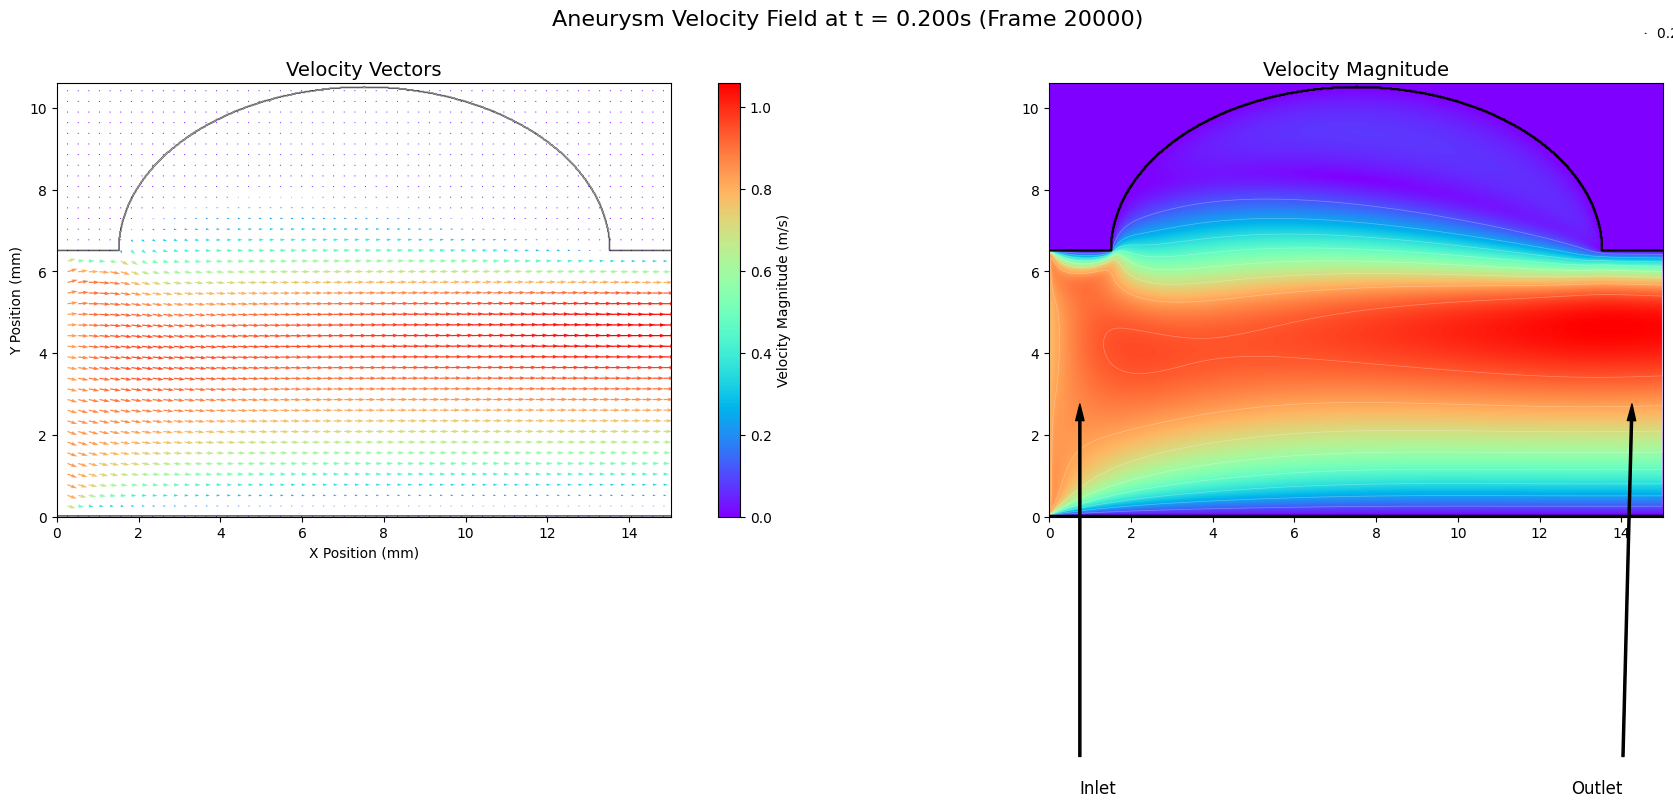


Velocity Statistics:
Mean velocity magnitude: 0.465897 m/s
Max velocity magnitude: 1.058914 m/s
Min velocity magnitude: 0.000000 m/s

Reynolds number: 913.69
Flow regime: Laminar


In [103]:
def visualize_velocity_field_three_panels(velocity_data):
    """Create a three-panel visualization with separate streamlines, vectors, and magnitude"""
    if velocity_data is None or 'u_x' not in velocity_data or 'u_y' not in velocity_data:
        print("No velocity data available to visualize")
        return
    
    # Extract data
    u = velocity_data['u_x']
    v = velocity_data['u_y']
    wall_mask = velocity_data.get('wall_mask', None)
    time_sec = velocity_data.get('time', 0.0)
    frame_num = velocity_data.get('frame', 0)
    
    # Calculate velocity magnitude
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain dimensions in physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Create meshgrid for quiver plot
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Create a 1x3 plot layout: streamlines, velocity vectors, and velocity magnitude
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 40)
    
    # Title for the entire figure
    fig.suptitle(f"Aneurysm Velocity Field at t = {time_sec:.3f}s (Frame {frame_num})", fontsize=16)
    
    # Common function to add domain boundary
    def add_domain_to_axis(ax):
        if wall_mask is not None:
            # Create a custom colormap for the domain
            domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
            ax.imshow(wall_mask, cmap=domain_cmap, alpha=0.2, origin='lower', extent=extent_mm)
            # Add domain boundary outline
            ax.contour(x_mm, y_mm, wall_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    # Plot 1: Streamlines only
    ax1.set_title('Flow Streamlines', fontsize=14)
    add_domain_to_axis(ax1)
    
    # Add streamlines with color based on velocity magnitude
    streamplot = ax1.streamplot(x_mm, y_mm, u_phys, v_phys, density=1.5,
                             color=vel_mag_phys, cmap='rainbow',
                             linewidth=2, arrowsize=1.5)
    
    # Add colorbar for streamlines
    cbar1 = plt.colorbar(streamplot.lines, ax=ax1)
    cbar1.set_label('Velocity Magnitude (m/s)')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Plot 2: Velocity vectors only
    ax2.set_title('Velocity Vectors', fontsize=14)
    add_domain_to_axis(ax2)
    
    # Add quiver plot (velocity vectors)
    quiver = ax2.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                      u_phys[::skip, ::skip], v_phys[::skip, ::skip],
                      vel_mag_phys[::skip, ::skip], cmap='rainbow',
                      scale=50, width=0.002)
    
    # Add quiver key for scale reference
    ax2.quiverkey(quiver, 0.9, 0.95, 0.2, r'0.2 m/s', labelpos='E', coordinates='figure')
    
    # Add colorbar for vectors
    cbar2 = plt.colorbar(quiver, ax=ax2)
    cbar2.set_label('Velocity Magnitude (m/s)')
    
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    ax2.grid(False)
    
    # Plot 3: Velocity magnitude heatmap
    ax3.set_title('Velocity Magnitude', fontsize=14)
    
    im = ax3.imshow(vel_mag_phys, origin='lower', cmap='rainbow', 
                   interpolation='bilinear', extent=extent_mm)
    
    # Add contour lines to better show flow patterns
    contour_levels = np.linspace(vel_mag_phys.min(), vel_mag_phys.max(), 10)
    ax3.contour(x_mm, y_mm, vel_mag_phys, levels=contour_levels, 
              colors='white', alpha=0.3, linewidths=0.5)
    
    # Add domain boundary if wall mask available
    if wall_mask is not None:
        ax3.contour(x_mm, y_mm, wall_mask, levels=[0.5], 
                  colors='black', linewidths=1.0)
    
    # Add annotations for key regions if dimensions match expectations
    vessel_center_y = None
    if 'vessel_centre_lu' in params.get('input_parameters', {}):
        vessel_center_y = params['input_parameters']['vessel_centre_lu'] * dx * 1000
    elif ny > 400:  # Approximate for typical aneurysm dimensions
        vessel_center_y = ny * dx * 1000 / 3  # Approximate vessel center
    
    if vessel_center_y is not None:
        # Domain width in mm
        domain_width_mm = nx * dx * 1000
        
        # Annotate key regions
        ax3.annotate('Inlet', xy=(domain_width_mm*0.05, vessel_center_y),
                    xytext=(domain_width_mm*0.05, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax3.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_y+15),
                    xytext=(domain_width_mm*0.5, vessel_center_y+30),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax3.annotate('Outlet', xy=(domain_width_mm*0.95, vessel_center_y),
                    xytext=(domain_width_mm*0.85, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    plt.show()
    
    # Print interesting flow features
    print("\nFlow Feature Analysis:")
    
    # Calculate vorticity (curl of velocity field)
    du_dy = np.gradient(u_phys, y_mm, axis=0)
    dv_dx = np.gradient(v_phys, x_mm, axis=1)
    vorticity = dv_dx - du_dy
    
    print(f"Maximum vorticity: {np.max(np.abs(vorticity)):.6f} 1/s")
    print(f"Mean flow velocity: {np.mean(vel_mag_phys):.6f} m/s")
    
    # Look for recirculation zones (areas with high vorticity magnitude)
    high_vorticity_threshold = np.percentile(np.abs(vorticity), 95)  # Top 5% of vorticity magnitude
    high_vorticity_areas = np.abs(vorticity) > high_vorticity_threshold
    
    if np.sum(high_vorticity_areas) > 0:
        print(f"Detected {np.sum(high_vorticity_areas)} points with high vorticity (potential recirculation zones)")
        
        # Report average location of high vorticity areas
        high_vort_y_indices, high_vort_x_indices = np.where(high_vorticity_areas)
        avg_x_mm = np.mean(x_mm[high_vort_x_indices])
        avg_y_mm = np.mean(y_mm[high_vort_y_indices])
        print(f"Average location of recirculation: x = {avg_x_mm:.2f} mm, y = {avg_y_mm:.2f} mm")
        
        # Optionally, plot the recirculation zones
        recirc_x = x_mm[high_vort_x_indices]
        recirc_y = y_mm[high_vort_y_indices]
        
        plt.figure(figsize=(10, 8))
        plt.scatter(recirc_x, recirc_y, c='red', s=10, label='Recirculation Zones')
        plt.title(f"Detected Recirculation Zones (High Vorticity Areas)")
        plt.xlabel('X Position (mm)')
        plt.ylabel('Y Position (mm)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No significant recirculation zones detected")

# Load velocity data at t=0.2s
velocity_field_t02 = load_velocity_at_time(target_time=0.2)

# Visualize the velocity field
if velocity_field_t02:
    visualize_velocity_field_at_time(velocity_field_t02)
else:
    print("Could not load velocity field data for t=0.2s")

## Enhanced Velocity Field Visualization with Separate Streamlines and Vectors

Create a three-panel visualization showing streamlines, velocity vectors, and velocity magnitude separately for better analysis of the flow patterns.

Loading velocity field at t = 0.200s (frame 20000, closest to target t = 0.2s)


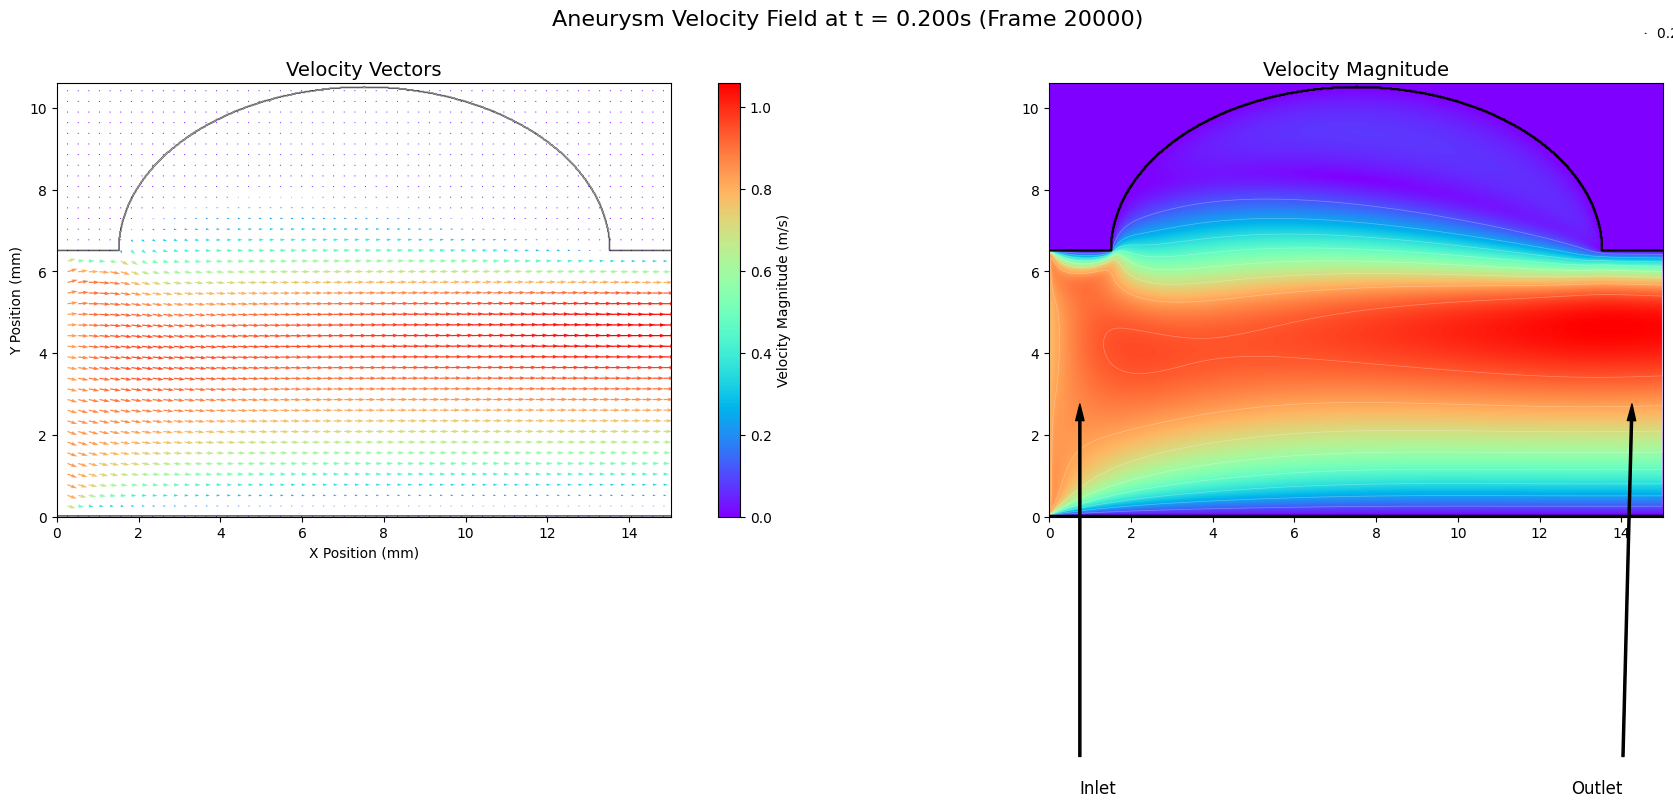


Velocity Statistics:
Mean velocity magnitude: 0.465897 m/s
Max velocity magnitude: 1.058914 m/s
Min velocity magnitude: 0.000000 m/s

Reynolds number: 913.69
Flow regime: Laminar


In [104]:
def visualize_velocity_field_three_panels(velocity_data):
    """Create a three-panel visualization with separate streamlines, vectors, and magnitude"""
    if velocity_data is None or 'u_x' not in velocity_data or 'u_y' not in velocity_data:
        print("No velocity data available to visualize")
        return
    
    # Extract data
    u = velocity_data['u_x']
    v = velocity_data['u_y']
    wall_mask = velocity_data.get('wall_mask', None)
    time_sec = velocity_data.get('time', 0.0)
    frame_num = velocity_data.get('frame', 0)
    
    # Calculate velocity magnitude
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain dimensions in physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Create meshgrid for quiver plot
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Create a 1x3 plot layout: streamlines, velocity vectors, and velocity magnitude
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 40)
    
    # Title for the entire figure
    fig.suptitle(f"Aneurysm Velocity Field at t = {time_sec:.3f}s (Frame {frame_num})", fontsize=16)
    
    # Common function to add domain boundary
    def add_domain_to_axis(ax):
        if wall_mask is not None:
            # Create a custom colormap for the domain
            domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
            ax.imshow(wall_mask, cmap=domain_cmap, alpha=0.2, origin='lower', extent=extent_mm)
            # Add domain boundary outline
            ax.contour(x_mm, y_mm, wall_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    # Plot 1: Streamlines only
    ax1.set_title('Flow Streamlines', fontsize=14)
    add_domain_to_axis(ax1)
    
    # Add streamlines with color based on velocity magnitude
    streamplot = ax1.streamplot(x_mm, y_mm, u_phys, v_phys, density=1.5,
                             color=vel_mag_phys, cmap='rainbow',
                             linewidth=2, arrowsize=1.5)
    
    # Add colorbar for streamlines
    cbar1 = plt.colorbar(streamplot.lines, ax=ax1)
    cbar1.set_label('Velocity Magnitude (m/s)')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Plot 2: Velocity vectors with adjustable density
    ax2.set_title(f'Velocity Vectors (1/{skip} density)', fontsize=14)
    add_domain_to_axis(ax2)
    
    # Create quiver plot with customizable density and auto-sized arrows
    quiver = ax2.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                      u_phys[::skip, ::skip], v_phys[::skip, ::skip],
                      vel_mag_phys[::skip, ::skip], cmap='rainbow',
                      scale=50, width=0.002)
    
    # Add quiver key for scale reference
    ax2.quiverkey(quiver, 0.9, 0.95, 0.2, r'0.2 m/s', labelpos='E', coordinates='figure')
    
    # Add colorbar for vectors
    cbar2 = plt.colorbar(quiver, ax=ax2)
    cbar2.set_label('Velocity Magnitude (m/s)')
    
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    ax2.grid(False)
    
    # Plot 3: Velocity magnitude heatmap
    ax3.set_title('Velocity Magnitude', fontsize=14)
    
    im = ax3.imshow(vel_mag_phys, origin='lower', cmap='rainbow', 
                   interpolation='bilinear', extent=extent_mm)
    
    # Add contour lines to better show flow patterns
    contour_levels = np.linspace(vel_mag_phys.min(), vel_mag_phys.max(), 10)
    ax3.contour(x_mm, y_mm, vel_mag_phys, levels=contour_levels, 
              colors='white', alpha=0.3, linewidths=0.5)
    
    # Add domain boundary if wall mask available
    if wall_mask is not None:
        ax3.contour(x_mm, y_mm, wall_mask, levels=[0.5], 
                  colors='black', linewidths=1.0)
    
    # Add annotations for key regions if dimensions match expectations
    vessel_center_y = None
    if 'vessel_centre_lu' in params.get('input_parameters', {}):
        vessel_center_y = params['input_parameters']['vessel_centre_lu'] * dx * 1000
    elif ny > 400:  # Approximate for typical aneurysm dimensions
        vessel_center_y = ny * dx * 1000 / 3  # Approximate vessel center
    
    if vessel_center_y is not None:
        # Domain width in mm
        domain_width_mm = nx * dx * 1000
        
        # Annotate key regions
        ax3.annotate('Inlet', xy=(domain_width_mm*0.05, vessel_center_y),
                    xytext=(domain_width_mm*0.05, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax3.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_y+15),
                    xytext=(domain_width_mm*0.5, vessel_center_y+30),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax3.annotate('Outlet', xy=(domain_width_mm*0.95, vessel_center_y),
                    xytext=(domain_width_mm*0.85, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    plt.show()
    
    # Print interesting flow features
    print("\nFlow Feature Analysis:")
    
    # Calculate vorticity (curl of velocity field)
    du_dy = np.gradient(u_phys, y_mm, axis=0)
    dv_dx = np.gradient(v_phys, x_mm, axis=1)
    vorticity = dv_dx - du_dy
    
    print(f"Maximum vorticity: {np.max(np.abs(vorticity)):.6f} 1/s")
    print(f"Mean flow velocity: {np.mean(vel_mag_phys):.6f} m/s")
    
    # Look for recirculation zones (areas with high vorticity magnitude)
    high_vorticity_threshold = np.percentile(np.abs(vorticity), 95)  # Top 5% of vorticity magnitude
    high_vorticity_areas = np.abs(vorticity) > high_vorticity_threshold
    
    if np.sum(high_vorticity_areas) > 0:
        print(f"Detected {np.sum(high_vorticity_areas)} points with high vorticity (potential recirculation zones)")
        
        # Report average location of high vorticity areas
        high_vort_y_indices, high_vort_x_indices = np.where(high_vorticity_areas)
        avg_x_mm = np.mean(x_mm[high_vort_x_indices])
        avg_y_mm = np.mean(y_mm[high_vort_y_indices])
        print(f"Average location of recirculation: x = {avg_x_mm:.2f} mm, y = {avg_y_mm:.2f} mm")
        
        # Optionally, plot the recirculation zones
        recirc_x = x_mm[high_vort_x_indices]
        recirc_y = y_mm[high_vort_y_indices]
        
        plt.figure(figsize=(10, 8))
        plt.scatter(recirc_x, recirc_y, c='red', s=10, label='Recirculation Zones')
        plt.title(f"Detected Recirculation Zones (High Vorticity Areas)")
        plt.xlabel('X Position (mm)')
        plt.ylabel('Y Position (mm)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No significant recirculation zones detected")

# Load velocity data at t=0.2s
velocity_field_t02 = load_velocity_at_time(target_time=0.2)

# Visualize the velocity field
if velocity_field_t02:
    visualize_velocity_field_at_time(velocity_field_t02)
else:
    print("Could not load velocity field data for t=0.2s")

## Interactive Frame Browser

This interactive widget allows exploring the velocity field at different time frames with adjustable vector density.

Loading velocity field at t = 0.200s (frame 20000, closest to target t = 0.2s)


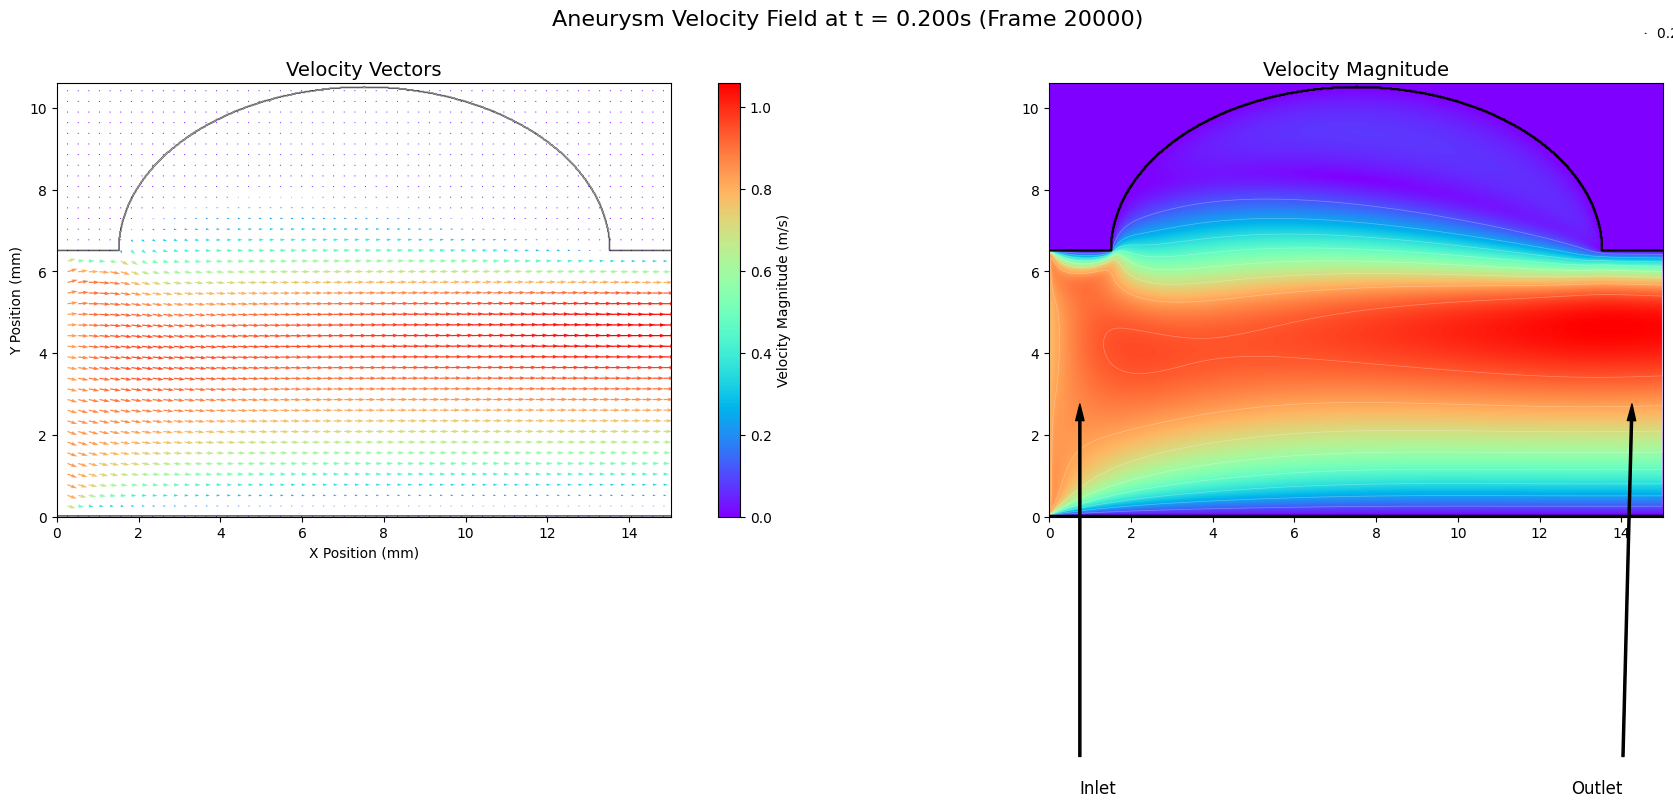


Flow Feature Analysis:
Maximum vorticity: 18.004820 1/s
Mean flow velocity: 0.465897 m/s
Detected 19902 points with high vorticity (potential recirculation zones)
Average location of recirculation: x = 7.04 mm, y = 3.94 mm


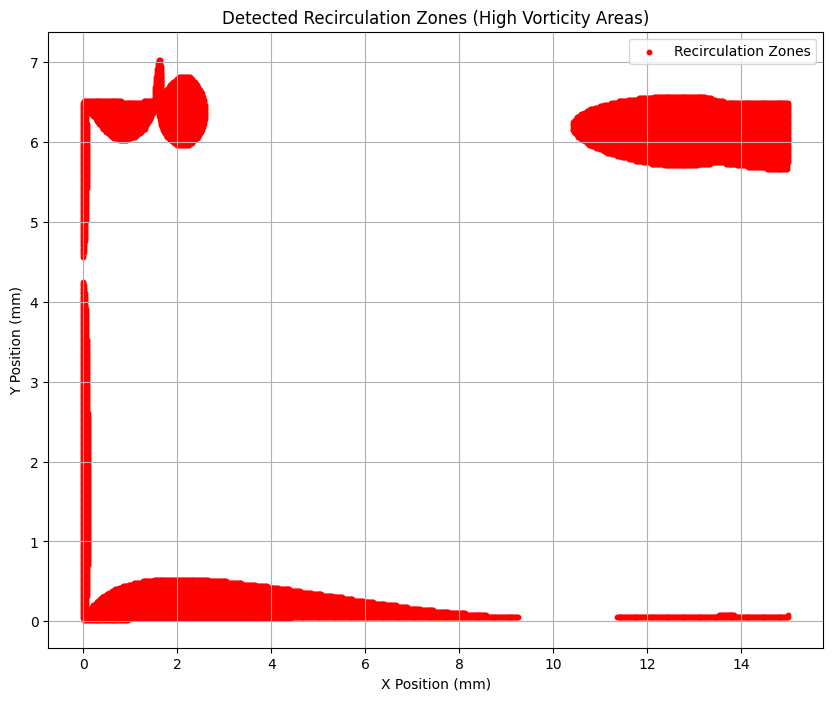

In [105]:
def browse_frames_interactive():
    """Create an interactive widget to browse through different time frames"""
    # Check if we have the necessary files
    if not processed_dir.exists():
        print(f"Processed data directory not found at {processed_dir}")
        return
    
    frame_mapping_file = processed_dir / 'frame_mapping.npz'
    u_x_file = processed_dir / 'u_x.npz'
    u_y_file = processed_dir / 'u_y.npz'
    
    if not all(f.exists() for f in [frame_mapping_file, u_x_file, u_y_file]):
        print("Required velocity data files not found.")
        return
    
    try:
        # Load frame information
        frame_mapping = np.load(frame_mapping_file)
        frame_numbers = frame_mapping['frame_numbers']
        
        # Convert to physical time
        physical_times = frame_numbers * dt
        
        # Find the frame closest to the target time
        target_idx = np.argmin(np.abs(physical_times - target_time))
        actual_time = physical_times[target_idx]
        frame_num = frame_numbers[target_idx]
        
        print(f"Loading velocity field at t = {actual_time:.3f}s (frame {frame_num}, closest to target t = {target_time:.1f}s)")
        
        # Load velocity components at the target time
        u_x_data = np.load(u_x_file)['data'][target_idx]
        u_y_data = np.load(u_y_file)['data'][target_idx]
        
        # Load wall mask if available
        wall_mask = None
        if wall_mask_file.exists():
            try:
                wall_mask_data = np.load(wall_mask_file)['data']
                if wall_mask_data.ndim == 3:  # Multi-frame data
                    wall_mask = wall_mask_data[target_idx]
                else:  # Single frame data
                    wall_mask = wall_mask_data
            except Exception as e:
                print(f"Error loading wall mask: {e}")
        
        return {
            'u_x': u_x_data,
            'u_y': u_y_data,
            'wall_mask': wall_mask,
            'time': actual_time,
            'frame': frame_num
        }
        
    except Exception as e:
        print(f"Error loading velocity field at specified time: {e}")
        import traceback
        traceback.print_exc()
        return None

def visualize_velocity_field_at_time(velocity_data):
    """Create comprehensive visualization of velocity field at specific time"""
    if velocity_data is None or 'u_x' not in velocity_data or 'u_y' not in velocity_data:
        print("No velocity data available to visualize")
        return
    
    # Extract data
    u = velocity_data['u_x']
    v = velocity_data['u_y']
    wall_mask = velocity_data.get('wall_mask', None)
    time_sec = velocity_data.get('time', 0.0)
    frame_num = velocity_data.get('frame', 0)
    
    # Calculate velocity magnitude
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain dimensions in physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Create meshgrid for quiver plot
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Create a 2x1 plot layout: velocity vectors and velocity magnitude
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 40)
    
    # Title for the entire figure
    fig.suptitle(f"Aneurysm Velocity Field at t = {time_sec:.3f}s (Frame {frame_num})", fontsize=16)
    
    # Plot 1: Vector field
    ax1.set_title('Velocity Vectors', fontsize=14)
    
    # If wall mask is available, use it to show the fluid domain
    if wall_mask is not None:
        # Create a custom colormap for the domain
        domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
        ax1.imshow(wall_mask, cmap=domain_cmap, alpha=0.2, origin='lower', extent=extent_mm)
        # Add domain boundary outline
        ax1.contour(x_mm, y_mm, wall_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    # Add quiver plot (velocity vectors)
    quiver = ax1.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                      u_phys[::skip, ::skip], v_phys[::skip, ::skip],
                      vel_mag_phys[::skip, ::skip], cmap='rainbow',
                      scale=50, width=0.002)
    
    # Add quiver key for scale reference
    ax1.quiverkey(quiver, 0.9, 0.95, 0.2, r'0.2 m/s', labelpos='E', coordinates='figure')
    
    # Add colorbar
    cbar1 = plt.colorbar(quiver, ax=ax1)
    cbar1.set_label('Velocity Magnitude (m/s)')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Plot 2: Velocity magnitude heatmap
    ax2.set_title('Velocity Magnitude', fontsize=14)
    
    im = ax2.imshow(vel_mag_phys, origin='lower', cmap='rainbow', 
                   interpolation='bilinear', extent=extent_mm)
    
    # Add contour lines to better show flow patterns
    contour_levels = np.linspace(vel_mag_phys.min(), vel_mag_phys.max(), 10)
    ax2.contour(x_mm, y_mm, vel_mag_phys, levels=contour_levels, 
              colors='white', alpha=0.3, linewidths=0.5)
    
    # Add domain boundary if wall mask available
    if wall_mask is not None:
        ax2.contour(x_mm, y_mm, wall_mask, levels=[0.5], 
                  colors='black', linewidths=1.0)
    
    # Add annotations for key regions if dimensions match expectations
    vessel_center_y = None
    if 'vessel_centre_lu' in params.get('input_parameters', {}):
        vessel_center_y = params['input_parameters']['vessel_centre_lu'] * dx * 1000
    elif ny > 400:  # Approximate for typical aneurysm dimensions
        vessel_center_y = ny * dx * 1000 / 3  # Approximate vessel center
    
    if vessel_center_y is not None:
        # Domain width in mm
        domain_width_mm = nx * dx * 1000
        
        # Annotate key regions
        ax2.annotate('Inlet', xy=(domain_width_mm*0.05, vessel_center_y), 
                    xytext=(domain_width_mm*0.05, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        # Look for region with higher velocity (potential aneurysm)
        # In typical aneurysm, the dome would be in the middle-top region
        ax2.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_y+15),
                    xytext=(domain_width_mm*0.5, vessel_center_y+30),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax2.annotate('Outlet', xy=(domain_width_mm*0.95, vessel_center_y),
                    xytext=(domain_width_mm*0.85, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()
    
    # Print interesting flow features
    print("\nFlow Feature Analysis:")
    
    # Calculate vorticity (curl of velocity field)
    du_dy = np.gradient(u_phys, y_mm, axis=0)
    dv_dx = np.gradient(v_phys, x_mm, axis=1)
    vorticity = dv_dx - du_dy
    
    print(f"Maximum vorticity: {np.max(np.abs(vorticity)):.6f} 1/s")
    print(f"Mean flow velocity: {np.mean(vel_mag_phys):.6f} m/s")
    
    # Look for recirculation zones (areas with high vorticity magnitude)
    high_vorticity_threshold = np.percentile(np.abs(vorticity), 95)  # Top 5% of vorticity magnitude
    high_vorticity_areas = np.abs(vorticity) > high_vorticity_threshold
    
    if np.sum(high_vorticity_areas) > 0:
        print(f"Detected {np.sum(high_vorticity_areas)} points with high vorticity (potential recirculation zones)")
        
        # Report average location of high vorticity areas
        high_vort_y_indices, high_vort_x_indices = np.where(high_vorticity_areas)
        avg_x_mm = np.mean(x_mm[high_vort_x_indices])
        avg_y_mm = np.mean(y_mm[high_vort_y_indices])
        print(f"Average location of recirculation: x = {avg_x_mm:.2f} mm, y = {avg_y_mm:.2f} mm")
        
        # Optionally, plot the recirculation zones
        recirc_x = x_mm[high_vort_x_indices]
        recirc_y = y_mm[high_vort_y_indices]
        
        plt.figure(figsize=(10, 8))
        plt.scatter(recirc_x, recirc_y, c='red', s=10, label='Recirculation Zones')
        plt.title(f"Detected Recirculation Zones (High Vorticity Areas)")
        plt.xlabel('X Position (mm)')
        plt.ylabel('Y Position (mm)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No significant recirculation zones detected")

# Load velocity data at t=0.2s
velocity_field_t02 = load_velocity_at_time(target_time=0.2)

# Visualize the velocity field
if velocity_field_t02:
    visualize_velocity_field_at_time(velocity_field_t02)
else:
    print("Could not load velocity field data for t=0.2s")

## Interactive Frame Browser

This interactive widget allows exploring the velocity field at different time frames with adjustable vector density.

Loading velocity field at t = 0.200s (frame 20000, closest to target t = 0.2s)


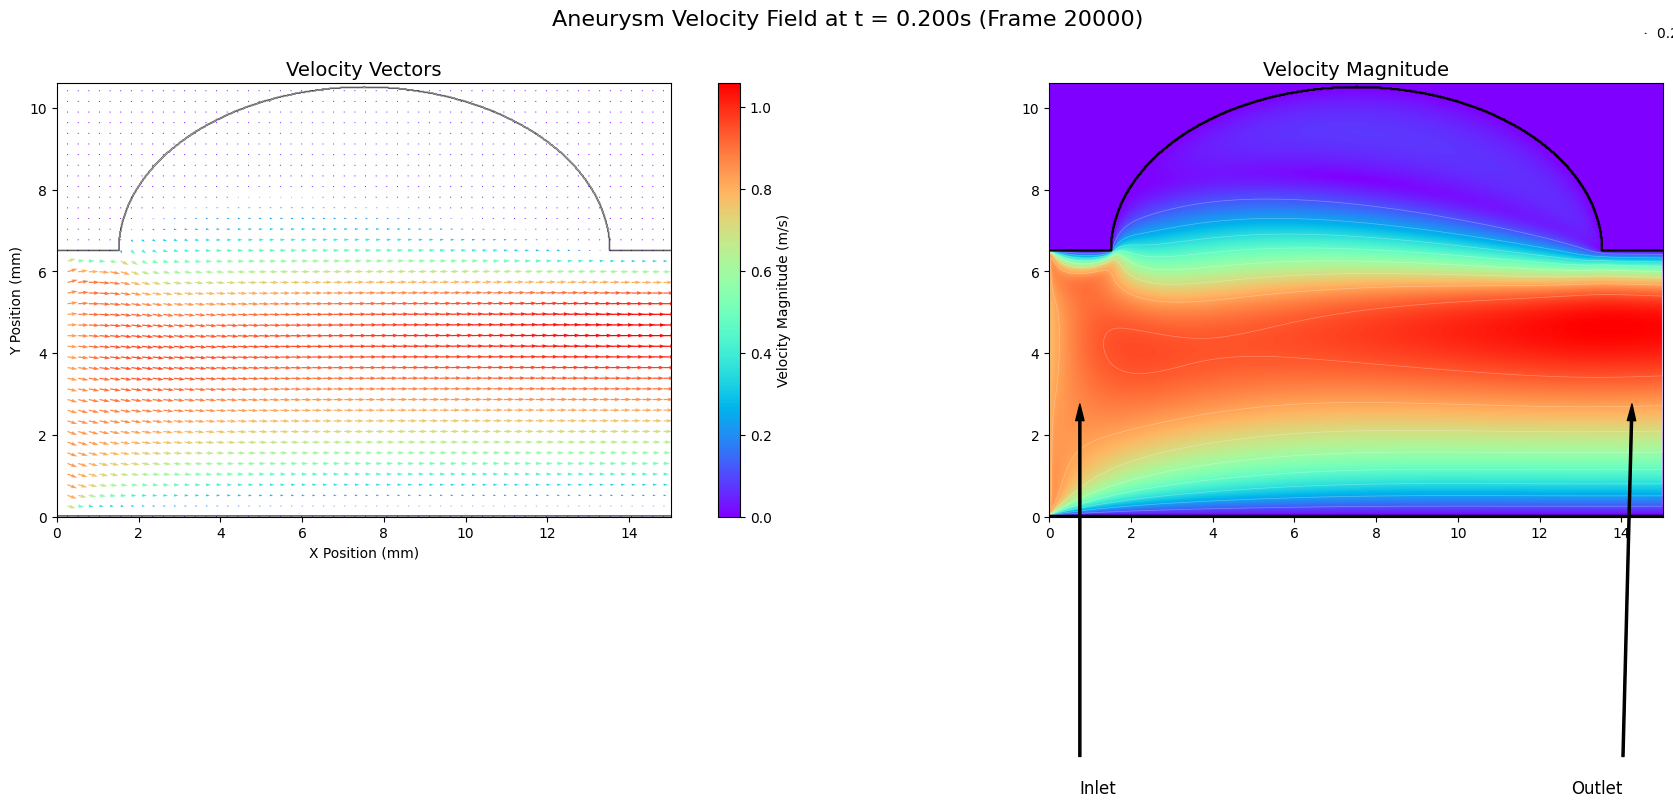


Flow Feature Analysis:
Maximum vorticity: 18.004820 1/s
Mean flow velocity: 0.465897 m/s
Detected 19902 points with high vorticity (potential recirculation zones)
Average location of recirculation: x = 7.04 mm, y = 3.94 mm


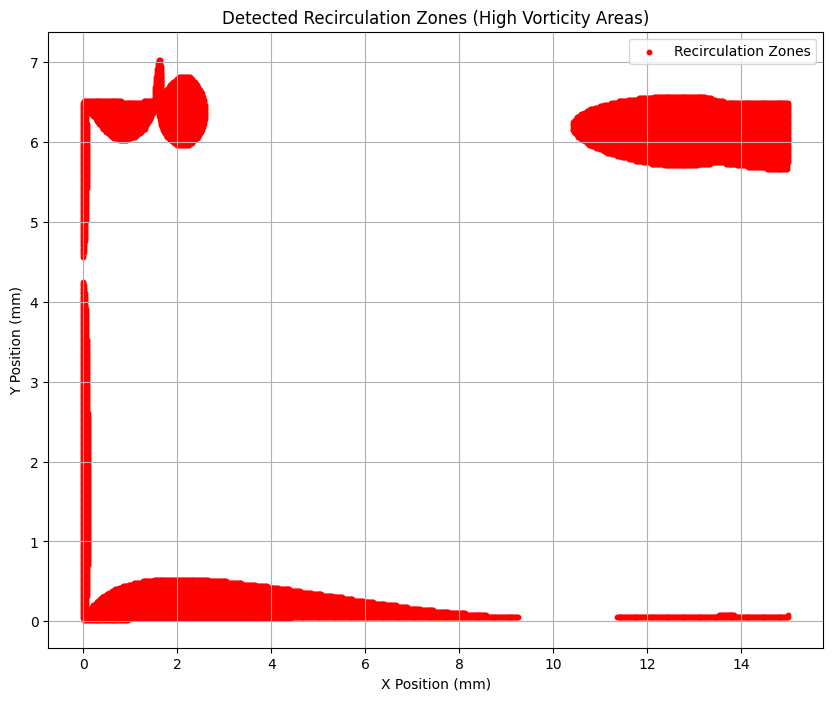

In [106]:
def browse_frames_interactive():
    """Create an interactive widget to browse through different time frames"""
    # Check if we have the necessary files
    if not processed_dir.exists():
        print(f"Processed data directory not found at {processed_dir}")
        return
    
    frame_mapping_file = processed_dir / 'frame_mapping.npz'
    u_x_file = processed_dir / 'u_x.npz'
    u_y_file = processed_dir / 'u_y.npz'
    
    if not all(f.exists() for f in [frame_mapping_file, u_x_file, u_y_file]):
        print("Required velocity data files not found.")
        return
    
    try:
        # Load frame information
        frame_mapping = np.load(frame_mapping_file)
        frame_numbers = frame_mapping['frame_numbers']
        
        # Convert to physical time
        physical_times = frame_numbers * dt
        
        # Find the frame closest to the target time
        target_idx = np.argmin(np.abs(physical_times - target_time))
        actual_time = physical_times[target_idx]
        frame_num = frame_numbers[target_idx]
        
        print(f"Loading velocity field at t = {actual_time:.3f}s (frame {frame_num}, closest to target t = {target_time:.1f}s)")
        
        # Load velocity components at the target time
        u_x_data = np.load(u_x_file)['data'][target_idx]
        u_y_data = np.load(u_y_file)['data'][target_idx]
        
        # Load wall mask if available
        wall_mask = None
        if wall_mask_file.exists():
            try:
                wall_mask_data = np.load(wall_mask_file)['data']
                if wall_mask_data.ndim == 3:  # Multi-frame data
                    wall_mask = wall_mask_data[target_idx]
                else:  # Single frame data
                    wall_mask = wall_mask_data
            except Exception as e:
                print(f"Error loading wall mask: {e}")
        
        return {
            'u_x': u_x_data,
            'u_y': u_y_data,
            'wall_mask': wall_mask,
            'time': actual_time,
            'frame': frame_num
        }
        
    except Exception as e:
        print(f"Error loading velocity field at specified time: {e}")
        import traceback
        traceback.print_exc()
        return None

def visualize_velocity_field_at_time(velocity_data):
    """Create comprehensive visualization of velocity field at specific time"""
    if velocity_data is None or 'u_x' not in velocity_data or 'u_y' not in velocity_data:
        print("No velocity data available to visualize")
        return
    
    # Extract data
    u = velocity_data['u_x']
    v = velocity_data['u_y']
    wall_mask = velocity_data.get('wall_mask', None)
    time_sec = velocity_data.get('time', 0.0)
    frame_num = velocity_data.get('frame', 0)
    
    # Calculate velocity magnitude
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain dimensions in physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Create meshgrid for quiver plot
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Create a 2x1 plot layout: velocity vectors and velocity magnitude
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 40)
    
    # Title for the entire figure
    fig.suptitle(f"Aneurysm Velocity Field at t = {time_sec:.3f}s (Frame {frame_num})", fontsize=16)
    
    # Plot 1: Vector field
    ax1.set_title('Velocity Vectors', fontsize=14)
    
    # If wall mask is available, use it to show the fluid domain
    if wall_mask is not None:
        # Create a custom colormap for the domain
        domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
        ax1.imshow(wall_mask, cmap=domain_cmap, alpha=0.2, origin='lower', extent=extent_mm)
        # Add domain boundary outline
        ax1.contour(x_mm, y_mm, wall_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    # Add quiver plot (velocity vectors)
    quiver = ax1.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                      u_phys[::skip, ::skip], v_phys[::skip, ::skip],
                      vel_mag_phys[::skip, ::skip], cmap='rainbow',
                      scale=50, width=0.002)
    
    # Add quiver key for scale reference
    ax1.quiverkey(quiver, 0.9, 0.95, 0.2, r'0.2 m/s', labelpos='E', coordinates='figure')
    
    # Add colorbar
    cbar1 = plt.colorbar(quiver, ax=ax1)
    cbar1.set_label('Velocity Magnitude (m/s)')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Plot 2: Velocity magnitude heatmap
    ax2.set_title('Velocity Magnitude', fontsize=14)
    
    im = ax2.imshow(vel_mag_phys, origin='lower', cmap='rainbow', 
                   interpolation='bilinear', extent=extent_mm)
    
    # Add contour lines to better show flow patterns
    contour_levels = np.linspace(vel_mag_phys.min(), vel_mag_phys.max(), 10)
    ax2.contour(x_mm, y_mm, vel_mag_phys, levels=contour_levels, 
              colors='white', alpha=0.3, linewidths=0.5)
    
    # Add domain boundary if wall mask available
    if wall_mask is not None:
        ax2.contour(x_mm, y_mm, wall_mask, levels=[0.5], 
                  colors='black', linewidths=1.0)
    
    # Add annotations for key regions if dimensions match expectations
    vessel_center_y = None
    if 'vessel_centre_lu' in params.get('input_parameters', {}):
        vessel_center_y = params['input_parameters']['vessel_centre_lu'] * dx * 1000
    elif ny > 400:  # Approximate for typical aneurysm dimensions
        vessel_center_y = ny * dx * 1000 / 3  # Approximate vessel center
    
    if vessel_center_y is not None:
        # Domain width in mm
        domain_width_mm = nx * dx * 1000
        
        # Annotate key regions
        ax2.annotate('Inlet', xy=(domain_width_mm*0.05, vessel_center_y), 
                    xytext=(domain_width_mm*0.05, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        # Look for region with higher velocity (potential aneurysm)
        # In typical aneurysm, the dome would be in the middle-top region
        ax2.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_y+15),
                    xytext=(domain_width_mm*0.5, vessel_center_y+30),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
        
        ax2.annotate('Outlet', xy=(domain_width_mm*0.95, vessel_center_y),
                    xytext=(domain_width_mm*0.85, vessel_center_y-10),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                    color='black', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()
    
    # Print interesting flow features
    print("\nFlow Feature Analysis:")
    
    # Calculate vorticity (curl of velocity field)
    du_dy = np.gradient(u_phys, y_mm, axis=0)
    dv_dx = np.gradient(v_phys, x_mm, axis=1)
    vorticity = dv_dx - du_dy
    
    print(f"Maximum vorticity: {np.max(np.abs(vorticity)):.6f} 1/s")
    print(f"Mean flow velocity: {np.mean(vel_mag_phys):.6f} m/s")
    
    # Look for recirculation zones (areas with high vorticity magnitude)
    high_vorticity_threshold = np.percentile(np.abs(vorticity), 95)  # Top 5% of vorticity magnitude
    high_vorticity_areas = np.abs(vorticity) > high_vorticity_threshold
    
    if np.sum(high_vorticity_areas) > 0:
        print(f"Detected {np.sum(high_vorticity_areas)} points with high vorticity (potential recirculation zones)")
        
        # Report average location of high vorticity areas
        high_vort_y_indices, high_vort_x_indices = np.where(high_vorticity_areas)
        avg_x_mm = np.mean(x_mm[high_vort_x_indices])
        avg_y_mm = np.mean(y_mm[high_vort_y_indices])
        print(f"Average location of recirculation: x = {avg_x_mm:.2f} mm, y = {avg_y_mm:.2f} mm")
        
        # Optionally, plot the recirculation zones
        recirc_x = x_mm[high_vort_x_indices]
        recirc_y = y_mm[high_vort_y_indices]
        
        plt.figure(figsize=(10, 8))
        plt.scatter(recirc_x, recirc_y, c='red', s=10, label='Recirculation Zones')
        plt.title(f"Detected Recirculation Zones (High Vorticity Areas)")
        plt.xlabel('X Position (mm)')
        plt.ylabel('Y Position (mm)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No significant recirculation zones detected")

# Load velocity data at t=0.2s
velocity_field_t02 = load_velocity_at_time(target_time=0.2)

# Visualize the velocity field
if velocity_field_t02:
    visualize_velocity_field_at_time(velocity_field_t02)
else:
    print("Could not load velocity field data for t=0.2s")

## Wall Shear Stress (WSS) Visualization

Visualize both flow streamlines and Wall Shear Stress (WSS) magnitude and direction.

Visualizing WSS at t = 0.200s (Frame 20000)



Diagnostic - WSS Raw Data Statistics:
WSS X - Min: -4.70557632, Max: 1.31242451, Mean: 0.00001471
WSS Y - Min: -0.81894514, Max: 4.70557632, Mean: -0.00002176
WSS Magnitude - Min: 0.00000000, Max: 21.02466112, Mean: 0.00218434


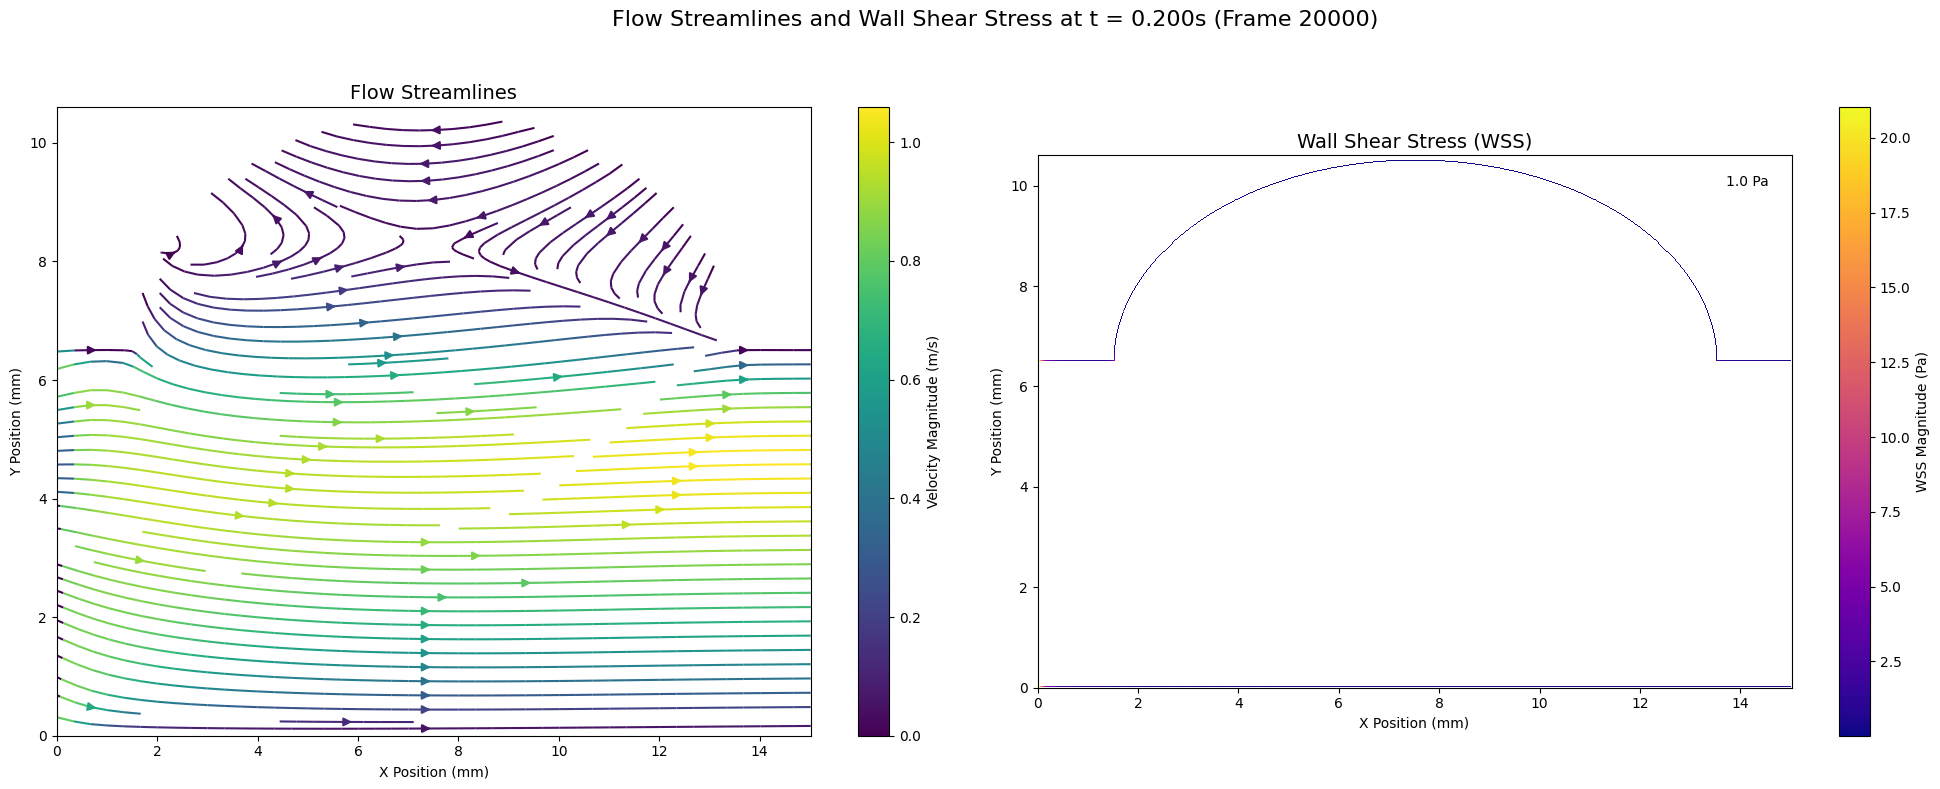


WSS Statistics for non-zero values:
Mean WSS: 0.537349 Pa
Max WSS: 21.024661 Pa
Min WSS: 0.011554 Pa
Number of non-zero WSS points: 1618


True

In [107]:
def visualize_wss_and_streamlines(frame_idx=20):
    """
    Visualize flow streamlines and Wall Shear Stress (WSS) at a specific time frame.
    The WSS is shown as arrows with length proportional to WSS magnitude.
    
    Parameters:
    - frame_idx: Index of the time frame to visualize
    """
    if not processed_dir.exists():
        print(f"Processed data directory not found at {processed_dir}")
        return
    
    # Files needed for visualization
    wss_x_file = processed_dir / 'wss_x.npz'
    wss_y_file = processed_dir / 'wss_y.npz'
    wss_mag_file = processed_dir / 'wss_magnitude.npz'
    u_x_file = processed_dir / 'u_x.npz'
    u_y_file = processed_dir / 'u_y.npz'
    frame_mapping_file = processed_dir / 'frame_mapping.npz'
    
    # Check if required files exist
    required_files = [wss_x_file, wss_y_file, u_x_file, u_y_file, frame_mapping_file]
    if not all(f.exists() for f in required_files):
        print("Some required data files not found:")
        for f in required_files:
            if not f.exists():
                print(f"  Missing: {f.name}")
        return
    
    try:
        # Load frame mapping to get physical time
        frame_mapping = np.load(frame_mapping_file)
        frame_numbers = frame_mapping['frame_numbers']
        physical_times = frame_mapping['physical_times'] if 'physical_times' in frame_mapping else frame_numbers * dt
        
        # Ensure frame_idx is valid
        frame_idx = min(frame_idx, len(frame_numbers)-1)
        current_time = physical_times[frame_idx]
        current_frame = frame_numbers[frame_idx]
        
        print(f"Visualizing WSS at t = {current_time:.3f}s (Frame {current_frame})")
        
        # Load wall shear stress components and magnitude
        wss_x = np.load(wss_x_file)['data'][frame_idx]
        wss_y = np.load(wss_y_file)['data'][frame_idx]
        
        # Load WSS magnitude if available, or calculate it
        if wss_mag_file.exists():
            wss_magnitude = np.load(wss_mag_file)['data'][frame_idx]
        else:
            wss_magnitude = np.sqrt(wss_x**2 + wss_y**2)
        
        # DIAGNOSTIC: Print WSS statistics
        print("\nDiagnostic - WSS Raw Data Statistics:")
        print(f"WSS X - Min: {wss_x.min():.8f}, Max: {wss_x.max():.8f}, Mean: {wss_x.mean():.8f}")
        print(f"WSS Y - Min: {wss_y.min():.8f}, Max: {wss_y.max():.8f}, Mean: {wss_y.mean():.8f}")
        print(f"WSS Magnitude - Min: {wss_magnitude.min():.8f}, Max: {wss_magnitude.max():.8f}, Mean: {wss_magnitude.mean():.8f}")
        
        # Check if WSS values are very small (close to zero)   
        if wss_magnitude.max() < 1e-6:
            print("WARNING: All WSS values are very close to zero! This may indicate an issue with the simulation or data processing.")
        
        # Load velocity field for streamlines
        u_x = np.load(u_x_file)['data'][frame_idx]
        u_y = np.load(u_y_file)['data'][frame_idx]
        
        # Convert to physical units
        # For velocity: m/s
        velocity_scale = dx / dt
        u_phys = u_x * velocity_scale
        v_phys = u_y * velocity_scale
        
        # For WSS: Pa (N/m²)
        # Assuming WSS is already in physical units (Pa) or needs the same conversion
        wss_x_phys = wss_x
        wss_y_phys = wss_y
        wss_mag_phys = wss_magnitude
        
        # Get domain dimensions in physical units (mm)
        ny, nx = u_x.shape
        x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
        y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
        extent_mm = [0, max(x_mm), 0, max(y_mm)]
        
        # Create meshgrid for plotting
        X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
        
        # Create figure with two panels: flow streamlines and WSS
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f"Flow Streamlines and Wall Shear Stress at t = {current_time:.3f}s (Frame {current_frame})", fontsize=16)
        
        # Panel 1: Flow streamlines with velocity magnitude color
        ax1.set_title('Flow Streamlines', fontsize=14)
        
        # Create a velocity magnitude field for coloring
        vel_mag_phys = np.sqrt(u_phys**2 + v_phys**2)
        
        # Add streamlines
        streamplot = ax1.streamplot(x_mm, y_mm, u_phys, v_phys, density=1.5,
                                 color=vel_mag_phys, cmap='viridis',
                                 linewidth=1.5, arrowsize=1.2)
        
        # Add colorbar
        cbar1 = plt.colorbar(streamplot.lines, ax=ax1)
        cbar1.set_label('Velocity Magnitude (m/s)')
        
        ax1.set_xlabel('X Position (mm)')
        ax1.set_ylabel('Y Position (mm)')
        
        # Panel 2: Wall Shear Stress visualization
        ax2.set_title('Wall Shear Stress (WSS)', fontsize=14)
        
        # Apply a threshold to highlight only non-zero WSS values
        threshold = 0.0001  # Small threshold to remove noise but keep important data
        wss_thresholded = np.where(wss_mag_phys > threshold, wss_mag_phys, np.nan)
                                
        # Plot WSS magnitude as background color
        im = ax2.imshow(wss_thresholded, origin='lower', cmap='plasma', extent=extent_mm, 
                      interpolation='none', alpha=1.0)
        
        # Add colorbar
        cbar2 = plt.colorbar(im, ax=ax2)
        cbar2.set_label('WSS Magnitude (Pa)')
                
        # Downsample for clearer vector visualization
        skip = max(1, min(nx, ny) // 30)
        
        # Apply threshold to vectors too
        wss_x_thresh = np.where(wss_mag_phys > threshold, wss_x_phys, 0)
        wss_y_thresh = np.where(wss_mag_phys > threshold, wss_y_phys, 0)
        
        # Add quiver plot (WSS vectors)
        quiver = ax2.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                          wss_x_thresh[::skip, ::skip], wss_y_thresh[::skip, ::skip],
                          scale=10, width=0.002, color='white', alpha=0.8)
        
        # Add quiver key for scale reference
        ax2.quiverkey(quiver, 0.9, 0.95, 1.0, r'1.0 Pa', labelpos='E')
        
        ax2.set_xlabel('X Position (mm)')
        ax2.set_ylabel('Y Position (mm)')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        # Print statistics for non-zero WSS values
        non_zero_wss = wss_mag_phys[wss_mag_phys > threshold]
        if len(non_zero_wss) > 0:
            print(f"\nWSS Statistics for non-zero values:")
            print(f"Mean WSS: {np.mean(non_zero_wss):.6f} Pa")
            print(f"Max WSS: {np.max(non_zero_wss):.6f} Pa")
            print(f"Min WSS: {np.min(non_zero_wss):.6f} Pa")
            print(f"Number of non-zero WSS points: {len(non_zero_wss)}")
        else:
            print("\nNo non-zero WSS values found.")
        
        return True
        
    except Exception as e:
        print(f"Error visualizing WSS: {e}")
        import traceback
        traceback.print_exc()
        return False

# Visualize WSS at frame 20 (corresponds to t=0.2s)
visualize_wss_and_streamlines(frame_idx=20)

## Interactive Wall Shear Stress Visualization

This widget allows exploring the Wall Shear Stress patterns at different time frames.

In [108]:
def interactive_wss_visualization():
    """Create an interactive widget to visualize WSS at different time frames"""
    # Check if we have the necessary files
    if not processed_dir.exists():
        print(f"Processed data directory not found at {processed_dir}")
        return
    
    # Check if WSS files exist
    wss_x_file = processed_dir / 'wss_x.npz'
    wss_y_file = processed_dir / 'wss_y.npz'
    frame_mapping_file = processed_dir / 'frame_mapping.npz'
    
    if not all(f.exists() for f in [wss_x_file, wss_y_file, frame_mapping_file]):
        print("Required WSS data files not found.")
        print(f"Missing: {' '.join(str(f) for f in [wss_x_file, wss_y_file, frame_mapping_file] if not f.exists())}")
        return
    
    try:
        # Load frame information
        frame_mapping = np.load(frame_mapping_file)
        frame_numbers = frame_mapping['frame_numbers']
        
        # Convert to physical time if needed
        if 'physical_times' in frame_mapping:
            physical_times = frame_mapping['physical_times']
        else:
            physical_times = frame_numbers * dt
        
        print(f"Available frames: {len(frame_numbers)} (from t={physical_times[0]:.2f}s to t={physical_times[-1]:.2f}s)")
        
        # Create a subset of frames for more efficient interaction
        if len(frame_numbers) > 100:
            step = len(frame_numbers) // 100 + 1
            sampled_indices = list(range(0, len(frame_numbers), step))
            # Make sure to include the last frame
            if len(frame_numbers)-1 not in sampled_indices:
                sampled_indices.append(len(frame_numbers)-1)
            
            sampled_physical_times = physical_times[sampled_indices]
            sampled_frame_numbers = frame_numbers[sampled_indices]
        else:
            sampled_indices = list(range(len(frame_numbers)))
            sampled_physical_times = physical_times
            sampled_frame_numbers = frame_numbers
        
        # Function to visualize WSS at a specific frame
        def show_wss_at_frame(time_idx):
            # Convert from slider index to actual frame index
            frame_idx = sampled_indices[time_idx]
            
            # Update the time display
            current_time.value = f"<b>Current time:</b> {physical_times[frame_idx]:.3f}s (Frame {frame_numbers[frame_idx]})"
            
            # Call the WSS visualization function
            visualize_wss_and_streamlines(frame_idx=frame_idx)
        
        # Create time display widget
        current_time = widgets.HTML(
            value=f"<b>Current time:</b> {sampled_physical_times[0]:.3f}s (Frame {sampled_frame_numbers[0]})",
            layout=widgets.Layout(margin='10px 0px')
        )
        
        # Create time slider
        time_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(sampled_indices)-1,
            step=1,
            description='Time frame:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='80%'),
            continuous_update=False  # Only update when sliding ends to prevent lag
        )
        
        # Add a play button for animation
        play_button = widgets.Play(
            value=0,
            min=0,
            max=len(sampled_indices)-1,
            step=1,
            interval=1000,  # milliseconds between frames (slower for WSS visualization)
            description="Play",
            disabled=False
        )
        
        # Link the play button to the time slider
        widgets.jslink((play_button, 'value'), (time_slider, 'value'))
        
        # Create controls container for play button and time slider
        time_controls = widgets.HBox([play_button, time_slider])
        
        # Add helpful description
        description = widgets.HTML(
            value=("<i>Visualizing Wall Shear Stress (WSS) over time. The arrows show the direction of WSS, "
                   "while the color shows the magnitude. High WSS regions may indicate potential areas of concern in aneurysms.</i>"),
            layout=widgets.Layout(margin='0px 0px 10px 0px', width='90%')
        )
        
        # Create controls layout
        controls = widgets.VBox([
            current_time,
            time_controls,
            description
        ])
        
        # Create the interactive widget
        print("Use the slider to select a time frame for WSS visualization:")
        print("You can also use the play button to animate through time.")
        
        # Create the main interactive widget
        interactive_widget = interactive(show_wss_at_frame, time_idx=time_slider)
        
        # Set the height of the output area to accommodate the visualizations
        output = interactive_widget.children[-1]
        output.layout.height = '800px'
        
        # Combine the controls and output in a single widget
        main_widget = widgets.VBox([controls, output])
        
        return main_widget
    
    except Exception as e:
        print(f"Error creating WSS interactive visualization: {e}")
        import traceback
        traceback.print_exc()
        return None

# Create and display the interactive WSS visualization
interactive_wss_widget = interactive_wss_visualization()
if interactive_wss_widget:
    display(interactive_wss_widget)

Available frames: 101 (from t=0.00s to t=1.00s)
Use the slider to select a time frame for WSS visualization:
You can also use the play button to animate through time.
